In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
from transformers import (
    GPT2Model,
    GPT2Tokenizer,
    GPT2PreTrainedModel,
    GPT2Config,
    Trainer,
    TrainingArguments
)
from datasets import Dataset as HFDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Load the data
df = pd.read_csv('author_ratings_normalized.csv', lineterminator='\n')

Reward statistics:
count    41527.000000
mean         0.498718
std          0.261682
min          0.000000
25%          0.239266
50%          0.498380
75%          0.757495
max          1.000000
Name: reward, dtype: float64


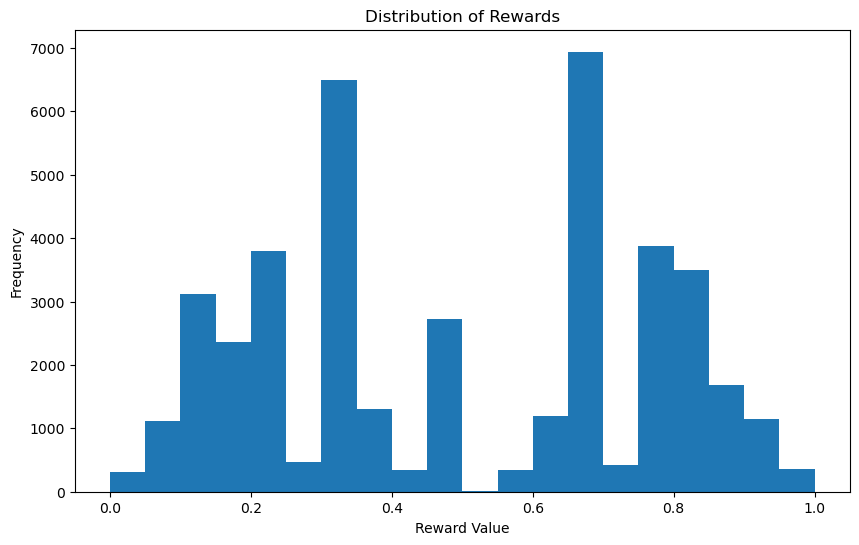

In [6]:
# Create pessimistic target 
a = .05
b = .1
df['reward_p'] = df['rating_norm'] - a*df['rd_norm'] - b*df['volatility_norm']
df['reward'] = df['rating_norm']
# Display reward statistics
print(f"Reward statistics:\n{df['reward'].describe()}")

# Plot reward distribution
plt.figure(figsize=(10, 6))
plt.hist(df['reward'], bins=20)
plt.title('Distribution of Rewards')
plt.xlabel('Reward Value')
plt.ylabel('Frequency')
plt.show()

# Ensure column names match expected format
if "question" not in df.columns and "questions" in df.columns:
    df = df.rename(columns={"questions": "question"})
if "answer" not in df.columns and "answers" in df.columns:
    df = df.rename(columns={"answers": "answer"})
if "reward" not in df.columns and "rewards" in df.columns:
    df = df.rename(columns={"rewards": "reward"})

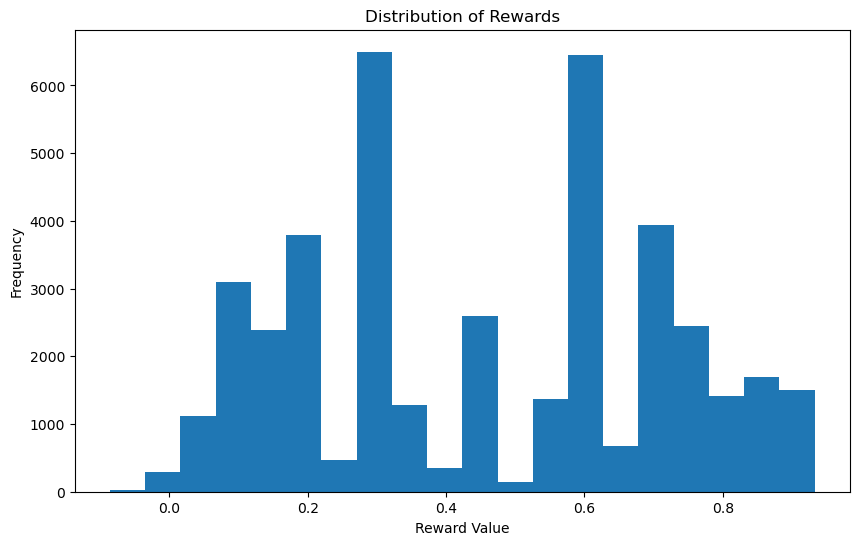

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(df['reward_p'], bins=20)
plt.title('Distribution of Rewards')
plt.xlabel('Reward Value')
plt.ylabel('Frequency')
plt.show()


In [8]:
class GPT2ForRegression(GPT2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        # Load pre-trained GPT-2
        self.gpt2 = GPT2Model(config)
        
        # Add a custom regression head
        self.regression_head = nn.Sequential(
            nn.Dropout(config.resid_pdrop),
            nn.Linear(config.hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # Single linear layer
        self.out_layer = nn.Linear(config.hidden_size, 1)
        
        # Initialize weights
        self.init_weights()
        
        # Freeze all GPT-2 parameters
        for param in self.gpt2.parameters():
            param.requires_grad = False
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None, **kwargs):
        
        # Get the output from GPT-2 base model
        with torch.no_grad():  # Ensure no gradients flow through GPT-2
            outputs = self.gpt2(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                position_ids=position_ids,
                head_mask=head_mask,
                inputs_embeds=inputs_embeds
            )
        
        # Get the last hidden state
        sequence_output = outputs[0]
        
        # Use the last token's representation
        batch_size = sequence_output.shape[0]
        last_token_ids = attention_mask.sum(dim=1) - 1
        last_token_ids = last_token_ids.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, sequence_output.size(-1))
        last_token_output = torch.gather(sequence_output, 1, last_token_ids).squeeze(1)
        
        # Pass through regression head
        #logits = self.regression_head(last_token_output).squeeze(-1)
        logits = self.out_layer(last_token_output).squeeze(-1)
        
        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(logits.view(-1), labels.view(-1))
        
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

# 3. Setup Data Processing Functions
# --------------------------------

# Define tokenization function
def tokenize_function(examples, tokenizer, max_length=512):
    questions = examples["question"]
    answers = examples["answer"]
    
    # Combine question and answer pairs
    texts = [f"Question: {q} Answer: {a}" for q, a in zip(questions, answers)]
    
    # Tokenize the texts
    tokenized = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    
    return tokenized

# Create a dataset preparation function
def prepare_dataset(examples, tokenized_examples, p):
    if p:
        return {
            'input_ids': tokenized_examples['input_ids'],
            'attention_mask': tokenized_examples['attention_mask'],
            'labels': examples['reward_p']
        }
    else:
        return {
            'input_ids': tokenized_examples['input_ids'],
            'attention_mask': tokenized_examples['attention_mask'],
            'labels': examples['reward']
        }
        
# Function to predict reward for a question-answer pair
def predict_reward(question, answer, model, tokenizer, device=None):
    """
    Predict the reward for a given question-answer pair
    
    Args:
        question (str): The question
        answer (str): The answer
        model: The trained reward model
        tokenizer: The tokenizer
        device: The device to use for prediction
        
    Returns:
        float: The predicted reward
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    model.eval()
    
    # Tokenize input
    text = f"Question: {question} Answer: {answer}"
    encoded_input = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )
    
    # Move inputs to device
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    
    # Make prediction
    with torch.no_grad():
        outputs = model(**encoded_input)
        prediction = outputs["logits"].item()
    
    return prediction

In [11]:
# Limit the data size for faster training in this example
data_lim = 50000  # Adjust based on available computational resources

# Split data into train and validation sets
#train_df, eval_df = train_test_split(df.sample(data_lim), test_size=0.2, random_state=42)
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(eval_df)}")

# Load pre-trained GPT-2 tokenizer
model_name = "gpt2"  # Options: "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a pad token by default

Training set size: 33221
Validation set size: 8306


In [12]:
# Create datasets
train_dataset = HFDataset.from_pandas(train_df)
eval_dataset = HFDataset.from_pandas(eval_df)

# Tokenize datasets
tokenized_train = train_dataset.map(
    lambda examples: tokenize_function(examples, tokenizer),
    batched=True
)

tokenized_eval = eval_dataset.map(
    lambda examples: tokenize_function(examples, tokenizer),
    batched=True
)

# Prepare final datasets
processed_train = tokenized_train.map(
    lambda examples: prepare_dataset(examples, tokenize_function(examples, tokenizer), False),
    batched=True,
    remove_columns=[col for col in tokenized_train.column_names if col not in ['input_ids', 'attention_mask', 'labels']]
)
processed_train_p = tokenized_train.map(
    lambda examples: prepare_dataset(examples, tokenize_function(examples, tokenizer), True),
    batched=True,
    remove_columns=[col for col in tokenized_train.column_names if col not in ['input_ids', 'attention_mask', 'labels']]
)

processed_eval = tokenized_eval.map(
    lambda examples: prepare_dataset(examples, tokenize_function(examples, tokenizer), False),
    batched=True,
    remove_columns=[col for col in tokenized_eval.column_names if col not in ['input_ids', 'attention_mask', 'labels']]
)
processed_eval_p = tokenized_eval.map(
    lambda examples: prepare_dataset(examples, tokenize_function(examples, tokenizer), True),
    batched=True,
    remove_columns=[col for col in tokenized_eval.column_names if col not in ['input_ids', 'attention_mask', 'labels']]
)

# Format for torch tensors
processed_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
processed_eval.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/33221 [00:00<?, ? examples/s]

Map:   0%|          | 0/8306 [00:00<?, ? examples/s]

Map:   0%|          | 0/33221 [00:00<?, ? examples/s]

Map:   0%|          | 0/33221 [00:00<?, ? examples/s]

Map:   0%|          | 0/8306 [00:00<?, ? examples/s]

Map:   0%|          | 0/8306 [00:00<?, ? examples/s]

In [14]:
# 6. Initialize the Model
# ---------------------

# Load GPT-2 configuration
config = GPT2Config.from_pretrained(model_name)

# Initialize our model with pre-trained GPT-2
model = GPT2ForRegression.from_pretrained(model_name, config=config)
model_p = GPT2ForRegression.from_pretrained(model_name, config=config)


# Verify that GPT-2 parameters are frozen and only regression head is trainable
total_params = 0
trainable_params = 0
for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()

for name, param in model_p.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
        
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Percentage of trainable parameters: {trainable_params/total_params:.2%}")

Some weights of GPT2ForRegression were not initialized from the model checkpoint at gpt2 and are newly initialized: ['gpt2.h.0.attn.c_attn.bias', 'gpt2.h.0.attn.c_attn.weight', 'gpt2.h.0.attn.c_proj.bias', 'gpt2.h.0.attn.c_proj.weight', 'gpt2.h.0.ln_1.bias', 'gpt2.h.0.ln_1.weight', 'gpt2.h.0.ln_2.bias', 'gpt2.h.0.ln_2.weight', 'gpt2.h.0.mlp.c_fc.bias', 'gpt2.h.0.mlp.c_fc.weight', 'gpt2.h.0.mlp.c_proj.bias', 'gpt2.h.0.mlp.c_proj.weight', 'gpt2.h.1.attn.c_attn.bias', 'gpt2.h.1.attn.c_attn.weight', 'gpt2.h.1.attn.c_proj.bias', 'gpt2.h.1.attn.c_proj.weight', 'gpt2.h.1.ln_1.bias', 'gpt2.h.1.ln_1.weight', 'gpt2.h.1.ln_2.bias', 'gpt2.h.1.ln_2.weight', 'gpt2.h.1.mlp.c_fc.bias', 'gpt2.h.1.mlp.c_fc.weight', 'gpt2.h.1.mlp.c_proj.bias', 'gpt2.h.1.mlp.c_proj.weight', 'gpt2.h.10.attn.c_attn.bias', 'gpt2.h.10.attn.c_attn.weight', 'gpt2.h.10.attn.c_proj.bias', 'gpt2.h.10.attn.c_proj.weight', 'gpt2.h.10.ln_1.bias', 'gpt2.h.10.ln_1.weight', 'gpt2.h.10.ln_2.bias', 'gpt2.h.10.ln_2.weight', 'gpt2.h.10.mlp.

Total parameters: 249931780
Trainable parameters: 1052164
Percentage of trainable parameters: 0.42%


In [ ]:
# Setup training arguments
training_args = TrainingArguments(
    output_dir="./results/gpt2-reward-model-frozen",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,  # Higher learning rate since we're only training the head
    per_device_train_batch_size=16,  # Can be higher with frozen GPT-2
    per_device_eval_batch_size=16,
    num_train_epochs=20,  # Adjust based on your needs
    weight_decay=0.01,
    load_best_model_at_end=True,
    greater_is_better=False,
    push_to_hub=False,
    disable_tqdm=False,
    report_to="none",
    logging_dir="./logs",
    logging_steps=10,
    logging_first_step=True,
)
# Create a compute_metrics function for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    mse = ((predictions - labels) ** 2).mean().item()
    return {"mse": mse}
# Set up the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_train,
    eval_dataset=processed_eval,
    compute_metrics=compute_metrics,
)
trainer_p = Trainer(
    model=model_p,
    args=training_args,
    train_dataset=processed_train_p,
    eval_dataset=processed_eval_p,
    compute_metrics=compute_metrics,
)

In [16]:
# Train the model (base reward)
print("Starting model training...")
trainer.train()

Starting model training...


Epoch,Training Loss,Validation Loss,Mse
1,0.085800,0.077989,0.077989
2,0.085700,0.075704,0.075704
3,0.070900,0.079978,0.079978
4,0.066300,0.072365,0.072365


TrainOutput(global_step=8308, training_loss=0.08297153314432962, metrics={'train_runtime': 3371.3818, 'train_samples_per_second': 39.415, 'train_steps_per_second': 2.464, 'total_flos': 3.4936287389147136e+16, 'train_loss': 0.08297153314432962, 'epoch': 4.0})

In [17]:
# Train the model (pessimistic reward)
print("Starting model training...")
trainer_p.train()

Starting model training...


Epoch,Training Loss,Validation Loss,Mse
1,0.095300,0.077712,0.077712
2,0.084600,0.080836,0.080836
3,0.069000,0.081436,0.081436
4,0.066200,0.072027,0.072027


TrainOutput(global_step=8308, training_loss=0.08300142624398867, metrics={'train_runtime': 3399.2705, 'train_samples_per_second': 39.092, 'train_steps_per_second': 2.444, 'total_flos': 3.4936287389147136e+16, 'train_loss': 0.08300142624398867, 'epoch': 4.0})

In [18]:
# Save the model
model_save_path = "./gpt2-reward-model-frozen-base"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to ./gpt2-reward-model-frozen-base


Getting predictions: 100%|████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 36.50it/s]


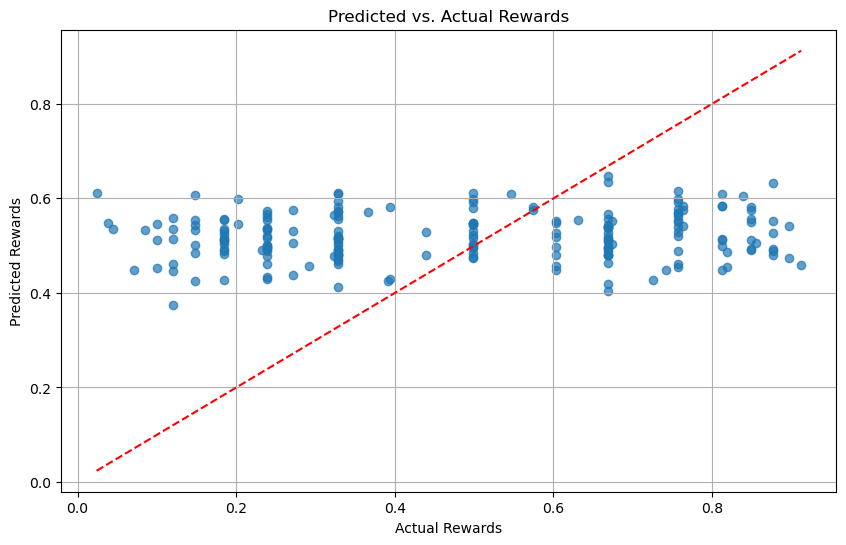

Mean Squared Error: 0.0648
Mean Absolute Error: 0.2251
R² Score: -0.0219


In [25]:
# Load the best model
model = GPT2ForRegression.from_pretrained(model_save_path)
model.to(device)

# Sample data from eval set for visualization
num_samples = 200  # Adjust based on your computational resources
sampled_df = eval_df.sample(min(num_samples, len(eval_df)))
actual_rewards = sampled_df['reward'].tolist()
predicted_rewards = []

# Get predictions
for i, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc="Getting predictions"):
    question = row['question']
    answer = row['answer']
    pred_reward = predict_reward(question, answer, model, tokenizer, device)
    predicted_rewards.append(pred_reward)

# Calculate metrics
mse = mean_squared_error(actual_rewards, predicted_rewards)
mae = mean_absolute_error(actual_rewards, predicted_rewards)
r2 = r2_score(actual_rewards, predicted_rewards)

# Plot predicted vs. actual rewards
plt.figure(figsize=(10, 6))
plt.scatter(actual_rewards, predicted_rewards, alpha=0.7)
plt.plot([min(actual_rewards), max(actual_rewards)], 
         [min(actual_rewards), max(actual_rewards)], 'r--')
plt.xlabel('Actual Rewards')
plt.ylabel('Predicted Rewards')
plt.title('Predicted vs. Actual Rewards')
plt.grid(True)
plt.show()

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

In [20]:
# Try with some sample questions and answers
sample_questions = [
    "What is the capital of France?",
    "How does photosynthesis work?",
    "What is the meaning of life?"
]

sample_answers = [
    "Paris is the capital of France.",
    "Photosynthesis is the process where plants convert sunlight, water and carbon dioxide into oxygen and glucose.",
    "The meaning of life is a philosophical question that has been debated for centuries."
]

# Make predictions
for q, a in zip(sample_questions, sample_answers):
    reward = predict_reward(q, a, model, tokenizer)
    print(f"Question: {q}")
    print(f"Answer: {a}")
    print(f"Predicted reward: {reward:.4f}\n")

Question: What is the capital of France?
Answer: Paris is the capital of France.
Predicted reward: 0.6127

Question: How does photosynthesis work?
Answer: Photosynthesis is the process where plants convert sunlight, water and carbon dioxide into oxygen and glucose.
Predicted reward: 0.6683

Question: What is the meaning of life?
Answer: The meaning of life is a philosophical question that has been debated for centuries.
Predicted reward: 0.5782



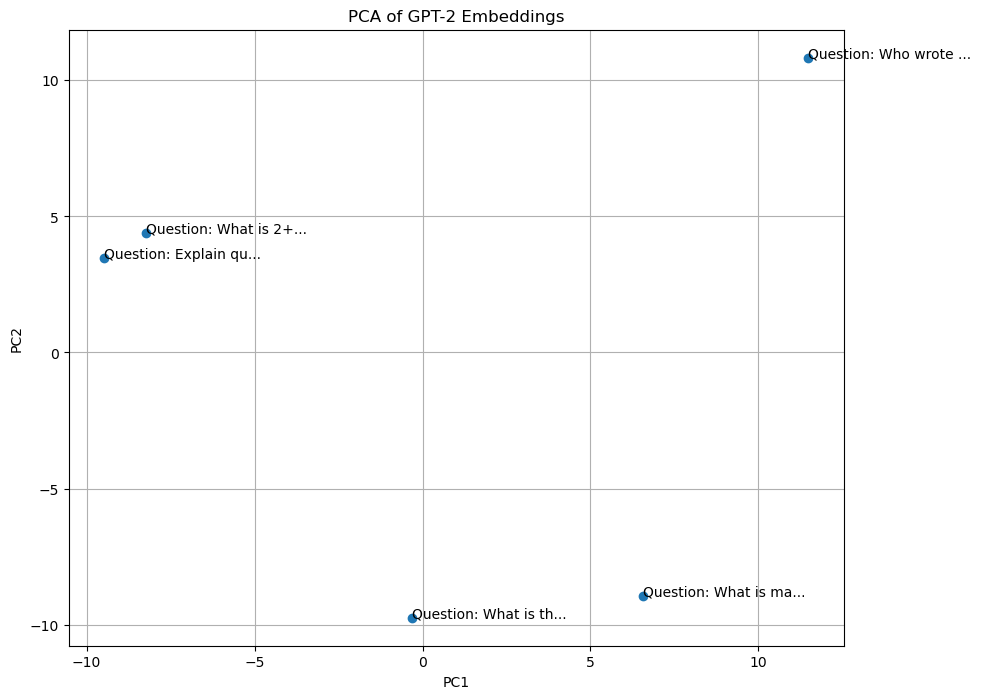

In [21]:
# Function to get and visualize embeddings from the model
def get_embeddings(texts, model, tokenizer, device=None):
    """Get embeddings from the GPT-2 model for visualization"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.to(device)
    model.eval()
    
    embeddings = []
    
    for text in texts:
        # Tokenize input
        encoded_input = tokenizer(
            text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=512
        )
        
        # Move inputs to device
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
        
        # Get the embedding
        with torch.no_grad():
            outputs = model.gpt2(**encoded_input)
            last_hidden_state = outputs.last_hidden_state
            
            # Get the last token embedding
            last_token_id = encoded_input['attention_mask'].sum(dim=1) - 1
            last_token_id = last_token_id.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, last_hidden_state.size(-1))
            last_token_embedding = torch.gather(last_hidden_state, 1, last_token_id).squeeze(1)
            
            embeddings.append(last_token_embedding.cpu().numpy())
    
    return np.vstack(embeddings)

# Try visualizing embeddings with PCA or t-SNE if desired
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Generate some example texts
example_texts = [
    "Question: What is 2+2? Answer: 4",
    "Question: What is the capital of France? Answer: Paris",
    "Question: Explain quantum physics. Answer: It's complicated",
    "Question: Who wrote Hamlet? Answer: Shakespeare",
    "Question: What is machine learning? Answer: A field of AI"
]

# Get embeddings
embeddings = get_embeddings(example_texts, model, tokenizer)

# Apply PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i, text in enumerate(example_texts):
    plt.annotate(text[:20] + "...", (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.title('PCA of GPT-2 Embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

Pessimistic

In [22]:
# Save the model
model_save_path = "./gpt2-reward-model-frozen-pess"
model_p.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./gpt2-reward-model-frozen-pess


Getting predictions: 100%|████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 39.62it/s]


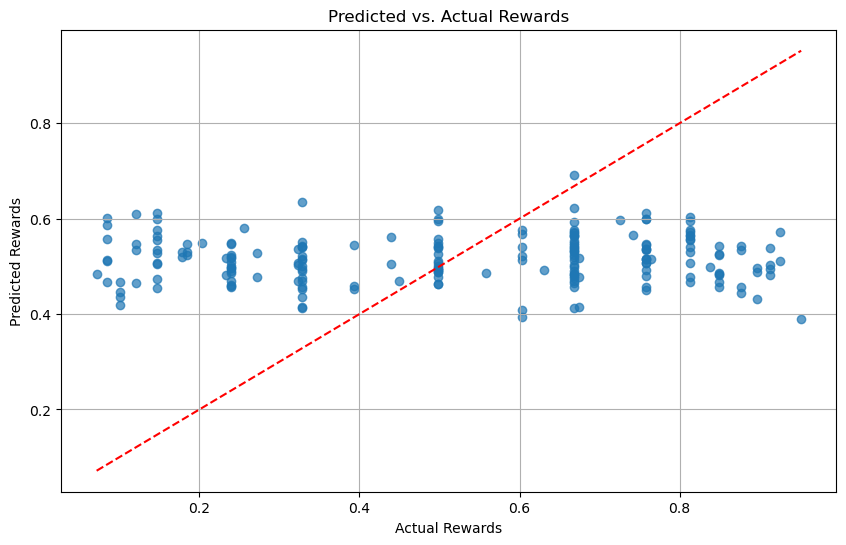

Mean Squared Error: 0.0684
Mean Absolute Error: 0.2275
R² Score: -0.0218


In [23]:
# Load the best model
model = GPT2ForRegression.from_pretrained(model_save_path)
model.to(device)

# Sample data from eval set for visualization
num_samples = 200  # Adjust based on your computational resources
sampled_df = eval_df.sample(min(num_samples, len(eval_df)))
actual_rewards = sampled_df['reward'].tolist()
predicted_rewards = []

# Get predictions
for i, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc="Getting predictions"):
    question = row['question']
    answer = row['answer']
    pred_reward = predict_reward(question, answer, model, tokenizer, device)
    predicted_rewards.append(pred_reward)

# Calculate metrics
mse = mean_squared_error(actual_rewards, predicted_rewards)
mae = mean_absolute_error(actual_rewards, predicted_rewards)
r2 = r2_score(actual_rewards, predicted_rewards)

# Plot predicted vs. actual rewards
plt.figure(figsize=(10, 6))
plt.scatter(actual_rewards, predicted_rewards, alpha=0.7)
plt.plot([min(actual_rewards), max(actual_rewards)], 
         [min(actual_rewards), max(actual_rewards)], 'r--')
plt.xlabel('Actual Rewards')
plt.ylabel('Predicted Rewards')
plt.title('Predicted vs. Actual Rewards')
plt.grid(True)
plt.show()

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")